In [1]:
from D090_Ala_scan import *
#%run D090_Ala_scan.py
init()

/home/colin/code/pyrosetta_tests/D090_Ala_scan.py:80: UserWarning: Import of 'rosetta' as a top-level module is deprecated and may be removed in 2018, import via 'pyrosetta.rosetta'.
  from rosetta.protocols.scoring import Interface


PyRosetta-4 2020 [Rosetta PyRosetta4.conda.linux.CentOS.python37.Release 2020.10+release.46415fa3e9decb8b6e91a4e065c15543eb27a461 2020-03-05T09:09:24] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.
core.init: {0} Checking for fconfig files in pwd and ./rosetta/flags
core.init: {0} Rosetta version: PyRosetta4.conda.linux.CentOS.python37.Release r248 2020.10+release.46415fa 46415fa3e9decb8b6e91a4e065c15543eb27a461 http://www.pyrosetta.org 2020-03-05T09:09:24
core.init: {0} command: PyRosetta -ex1 -ex2aro -database /home/colin/anaconda3/lib/python3.7/site-packages/pyrosetta/database
basic.random.init_random_generator: {0} 'RNG device' seed mode, using '/dev/urandom', seed=-1248219072 seed_offset=0 real_seed=-1248219072 thread_index=0
basic.random.init_random_generator: {0} RandomGenerator:init: Normal mode, seed=-1248219072 RG_type=mt19937


In [2]:
# performs general scanning editing here to make parallel
def scanning_parallel(pose_copy, partners, mutant_aa = 'A',
        interface_cutoff = 8.0, output = False,
        trials = 1, trial_output = ''):
    """
    Performs "scanning" at an interface within  <pdb_filename>  between
        <partners>  by mutating relevant residues to  <mutant_aa>  and repacking
        residues within  <pack_radius>  Angstroms, further repacking all
        residues within  <interface_cutoff>  of the interface residue, scoring
        the complex and subtracting the score of a pose with the partners
        separated by 500 Angstroms.
        <trials>  scans are performed (to average results) with summaries written
        to  <trial_output>_(trial#).txt.
        Structures are exported to a PyMOL instance.

    """
    # 1. set the pose
    pose = pose_copy

    # 2. setup the docking FoldTree and other related parameters
    dock_jump = 1
    movable_jumps = Vector1([dock_jump])
#    protocols.docking.setup_foldtree(pose, partners, movable_jumps)
# Commented out by colin because of error, found that API lists this method as below in PyRosetta4
    pyrosetta.rosetta.protocols.docking.setup_foldtree(pose, partners, movable_jumps)

    # 3. create ScoreFuncions for the Interface and "ddG" calculations
    # the pose's Energies objects MUST be updated for the Interface object to
    #    work normally
    scorefxn = get_fa_scorefxn() #  create_score_function('standard')
    scorefxn(pose)    # needed for proper Interface calculation

    # setup a "ddG" ScoreFunction, custom weights
    ddG_scorefxn = ScoreFunction()
    ddG_scorefxn.set_weight(core.scoring.fa_atr, 0.44)
    ddG_scorefxn.set_weight(core.scoring.fa_rep, 0.07)
    ddG_scorefxn.set_weight(core.scoring.fa_sol, 1.0)
    ddG_scorefxn.set_weight(core.scoring.hbond_bb_sc, 0.5)
    ddG_scorefxn.set_weight(core.scoring.hbond_sc, 1.0)

    # 4. create an Interface object for the pose
    interface = Interface(dock_jump)
    interface.distance(interface_cutoff)
    interface.calculate(pose)

    # 5. create a PyMOLMover for sending output to PyMOL (optional)
#     pymover = PyMOLMover()
#     pymover.keep_history(True)    # for multiple trajectories
#     pymover.apply(pose)
#     pymover.send_energy(pose)

    # 6. perform scanning trials
    # the large number of packing operations introduces a lot of variability,
    #    for best results, perform several trials and average the results,
    #    these score changes are useful to QUALITATIVELY defining "hotspot"
    #    residues
    # this script does not use a PyJobDistributor since no PDB files are output
    
    ddG_trials = []
    
    for trial in range( trials ):
        # store the ddG values in a dictionary
        ddG_mutants = {}
        for i in range(1, pose.total_residue() + 1):
            # for residues at the interface
            if interface.is_interface(i) == True:
                # this way you can TURN OFF output by providing False arguments
                #    (such as '', the default)
                filename = ''
                if output:
                    filename = pose.pdb_info().name()[:-4] + '_' +\
                        pose.sequence()[i-1] +\
                        str(pose.pdb_info().number(i)) + '->' + mutant_aa
                # determine the interace score change upon mutation
                key = pose.sequence()[i - 1] + str(pose.pdb_info().number(i)) + mutant_aa
                ddG_mutants[key] = interface_ddG(pose, i, mutant_aa,
                    movable_jumps, ddG_scorefxn, interface_cutoff, filename )
                
        ddG_trials.append(ddG_mutants)
        
    return ddG_trials

#         # output results
#         print( '='*80 )
#         print( 'Trial', str( trial + 1 ) )
#         print( 'Mutants (PDB numbered)\t\"ddG\" (interaction dependent score change)' )
#         residues = list( ddG_mutants.keys() )  # list(...) conversion is for python3 compatbility
#         residues.sort()    # easier to read
#         display = [pose.sequence()[i - 1] +
#             str(pose.pdb_info().number(i)) + mutant_aa + '\t' +
#             str(ddG_mutants[i]) + '\n'
#             for i in residues]
#         print( ''.join(display)[:-1] )
#         print( '='*80 )

#         # write to file
#         f = open(trial_output + '_' + str(trial + 1) + '.txt' , 'w' )
#         f.writelines(display)
#         f.close()

    #### alternate output using scanning_analysis (see below), only display
    ####    mutations with "deviant" score changes
    # commented out by colin
#     print( 'Likely Hotspot Residues' )
#     for hotspot in scanning_analysis(trial_output):
#         print( hotspot )
#     print( '='*80 )

# """
# 1.  creates a copy of the pose
# 2.  sets up a specific "ddG" ScoreFunction (if no ScoreFunction is provided)
# 3.  creates a copy of the pose to mutate
# 4.  mutates a single residue using mutate_residue
# 5.  calculates the "interaction energy" ( or "binding energy")
# 6.  outputs structures (optionally):
#         -to PyMOL
#         -to a PDB file
# """

In [3]:
#test the method
pdb_filename = "./native_test.pdb"
original_pose = Pose()
pose_from_file(original_pose, pdb_filename)

core.chemical.GlobalResidueTypeSet: {0} Finished initializing fa_standard residue type set.  Created 980 residue types
core.chemical.GlobalResidueTypeSet: {0} Total time to initialize 0.8622 seconds.
core.import_pose.import_pose: {0} File './native_test.pdb' automatically determined to be of type PDB
core.conformation.Conformation: {0} [ WARNING ] missing heavyatom:  CD  on residue GLU 24
core.conformation.Conformation: {0} [ WARNING ] missing heavyatom:  OE1 on residue GLU 24
core.conformation.Conformation: {0} [ WARNING ] missing heavyatom:  OE2 on residue GLU 24
core.conformation.Conformation: {0} [ WARNING ] missing heavyatom:  CG  on residue GLN 73
core.conformation.Conformation: {0} [ WARNING ] missing heavyatom:  CD  on residue GLN 73
core.conformation.Conformation: {0} [ WARNING ] missing heavyatom:  OE1 on residue GLN 73
core.conformation.Conformation: {0} [ WARNING ] missing heavyatom:  NE2 on residue GLN 73
core.conformation.Conformation: {0} [ WARNING ] missing heavyatom:  

Looks like Dask requires some pyrosetta.distributed packages. These appear to work best when things are submitted as rosettascripts. Will have to find some better sample rosettascripts later.

Try the pure python way:
``` python
from multiprocessing import Pool
import itertools
with pyrosetta.distributed.utility.log.LoggingContext(logging.getLogger("rosetta"), level=logging.WARN):
    with Pool() as p:
        work = [
            (input_pose, i, aa, "mutation")
            for i, aa in itertools.product(range(1, len(packed_pose.to_pose(input_pose).residues) + 1), IUPACData.protein_letters)
        ]
        logging.info("mutating")
        mutations = p.starmap(mutate_residue, work)
```

In [4]:
from multiprocessing import Pool

In [5]:
%%time
all_aas = ["A", "V", "I", "L", "L", "F", "Y", "W", "S", "T", "N", "Q", "G", "R", "H", "K", "D", "E"]
#all_aas = ["A", "V", 'I']
with Pool() as p:
    work = [(original_pose, "A_B", res, 8.0, False, 3) for res in all_aas]
    result = p.starmap(scanning_parallel, work)

core.scoring.ScoreFunctionFactory: {0} SCOREFUNCTION: ref2015
core.scoring.ScoreFunctionFactory: {0} SCOREFUNCTION: ref2015
core.pack.task: {0} Packer task: initialize from command line()
core.scoring.ScoreFunctionFactory: {0} SCOREFUNCTION: ref2015
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.scoring.ScoreFunctionFactory: {0} SCOREFUNCTION: ref2015
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteracti

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.scoring.ScoreFunctionFactory: {0} SCOREFUNCTION: ref2015
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.scoring.ScoreFunctionFactory: {0} SCOREFUNCTION: ref2015
core.pack.pack_rotamers: {0} built 143 rotamers at 10 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 98 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for inte

core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 96 rotame

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 143 rotamers at 10 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 143 rotamers at 10 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 98 rotamers at 10 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} R

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 143 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer ta

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 125 rotamers at 9 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
co

core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 173 rotamers at 9 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 3 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 18 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting 

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 216 rotamers at 9 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 173 rotamers at 9 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction grap

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 216 rotamers at 9 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 173 rotamers at 9 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 173 rotamers at 9 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.

core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 193 rotamers at 9 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} b

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 204 rotamers at 9 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 220 rotamers at 9 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 availabl

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 247 rotamers at 9 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 298 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 298 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.in

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 162 rotamers at 1 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 298 rotamers at 14 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all

core.pack.pack_rotamers: {0} built 298 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 298 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerS

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 371 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 371 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer tas

core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 338 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 420 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 360 rotamers at 14 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} 

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 210 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} built 394 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 6 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 210 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for int

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 210 rotamers at 11 positions.
c

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 257 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 210 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 263 rotamers at 13 positions.
core.pack.pack_rotamers: {0

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 325 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 262 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGra

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 441 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 268 rotamers at 11 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 441 rotamers at 13 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads 

core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 42 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0}

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.pack_rotamers: {0} built 441 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 441 rotamers at 13 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 10 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
cor

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 325 rotamers at 13 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 365 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 325 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computati

core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 263 rotamers at 14 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 285 rotamers at 13 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Inst

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 304 rotamers at 13 positions.
core.pack.pack_rotamers: {0} built 196 rotamers at 8 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 392 rotamers at 13 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} R

core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 8 rotamers at 1 positions.
core.pack.pack_rotamers: {0} built 210 rotamers at 8 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Complet

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 112 rotamers at 7 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 210 rotamers at 8 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested

core.pack.pack_rotamers: {0} built 190 rotamers at 7 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 112 rotamers at 7 positions.
core.pack.pack_rotamers: {0} Req

core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 263 rotamers at 8 positions.
core.pack.pack_rotamers: {0} built 268 rotamers at 8 positions.
core.pack.pack_rotamers: {0} built 190 rotamers at 7 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 253 rotamers at 8 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Reque

core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 263 rotamers at 8 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 5 rotamers at 1 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} built 112 rota

core.pack.pack_rotamers: {0} built 204 rotamers at 8 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 112 rotamers at 7 positions.
core.p

core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 194 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 263 rotamers at 8 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 190 rotamers at 7 positions.
core.pack.pack_rotamers: {0} bu

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 10 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 1

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 130 rotamers at 7 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 112 rotamers at 7 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 193 rotamers at 7 positions.
core.pack.pack_rotamers: {0} Req

core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 190 rotamers at 7 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 250 rotamers at 11 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 192 rotamers at 7 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.


core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 323 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 112 rotamers at 7 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction g

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 190 rotamers at 7 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 287 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: ini

core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 301 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 241 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 287 rotamers at 10 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 203 rotamers at 7 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requ

core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 268 rotamers at 11 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 202 rotamers at 8 positions.
core.pack.pack_rotamers: {0} built 250 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads f

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 194 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 327 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} b

core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 5 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 4 

core.pack.pack_rotamers: {0} built 380 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 105 rotamers at 8 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 2 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Insta

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 54 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pa

core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 185 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 105 rotamers at 8 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 205 rotamers at 8 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Insta

core.pack.pack_rotamers: {0} built 202 rotamers at 8 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 202 rotamers at 8 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph p

core.pack.pack_rotamers: {0} built 105 rotamers at 8 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 110 rotamers at 8 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer tas

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 125 rotamers at 8 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 155 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Re

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 185 rotamers at 11 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 155 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 86 rotamers at 10 position

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 147 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 119 rotamers at 8 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGr

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 220 rotamers at 8 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 86 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads

core.pack.pack_rotamers: {0} built 2 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 155 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating 

core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 86 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 86 rotamers at 10 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} R

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 98 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 157 rotamers at 10 positions.
core.pack.pack_rotamers: {0} built 8 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).


core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 89 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 157 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 88 rotamers at 10 positions

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 72 rotamers at 10 positions.
core.pack.pack_rotamers: {0} built 68 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 86 rotamers at 10 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.

core.pack.pack_rotamers: {0} built 12 rotamers at 1 positions.
core.pack.pack_rotamers: {0} built 215 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 16

core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 161 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 98 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 

core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 98 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 86 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 191 rotamers at 11 positions.


core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 157 rotamers at 10 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 86 rotamers at 10 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 422 rotamers at 15 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} In

core.pack.pack_rotamers: {0} built 157 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 421 rotamers at 15 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 113 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Re

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 184 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} bu

core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 157 rotamers at 10 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Request

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 421 rotamers at 15 positions.
core.pack.pack_rotamers: {0} built 105 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 421 rotamers at 15 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGrap

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 454 rotamers at 15 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 98 rotamers at 10 positions.
core.pack.pack_rotamers: {0} built 177 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.interaction_graph.in

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 482 rotamers at 15 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 311 rotamers at 11 positions.
core.pack.pack_rotamers: {0} bui

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 293 rotamers at 11 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available thread

core.pack.pack_rotamers: {0} built 422 rotamers at 15 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 422 rotamers at 15 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSet

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 311 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 421 rotamers at 15 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computatio

core.pack.pack_rotamers: {0} built 485 rotamers at 15 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 355 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 464 rotamers at 15 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 297 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computatio

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 354 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 295 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 298 rotamers at 11 positions.
core.pack.pack_rotamers: {0} built 311 rotamers at 11 positions.
core.pack.pack_rotamers: {0} R

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} built 329 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 301 rotamers at 11 positions.
core.p

core.pack.pack_rotamers: {0} built 311 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 364 rotamers at 13 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction 

core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 354 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 311 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 312 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 473 rotamers at 15 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer tas

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 312 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 311 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 avai

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 348 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interact

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 54 rotamers at 1 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 355 rotamers at 13 positions.
core.pack.pack_rotamers: {0} built 20 rotamers at 1 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interactio

core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 354 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 387 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 392 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computati

core.pack.pack_rotamers: {0} built 362 rotamers at 11 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 354 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 414 rotamers at 11 positions.
core.pack.pack_rotamers: {0} built 343 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been request

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 354 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 4 rotamers at 1 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pr

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 2 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 353 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 9 rotamers at 1 positions.
core.pa

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 344 rotamers at 14 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 393 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 392 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.Rotamer

core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 162 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.pack_rotamers: {0} built 7 rotamers at 1 positions.
core.pack.rotamer_set.RotamerSets: {0} 

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 344 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 344 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction gr

core.pack.pack_rotamers: {0} built 607 rotamers at 16 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 409 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 409 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} I

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 26 rotamers at 1 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 7 rotamers at 1 positions.
core.pack.pack_rotamers: {0} built 434 r

core.pack.pack_rotamers: {0} built 426 rotamers at 16 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 517 rotamers at 16 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 524 rotamers at 16 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computati

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 36 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 607 rotamers at 16 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 517 rotamers at 16 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 517 rotamers at 16 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGra

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: init

core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 9 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.pack_rotamers: {0} built 17 rotamers at 1 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.pack_rotamers: {0} built 255 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.int

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 275 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 293 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 517 rotamers at 16 positions.
core.pack.pack_rotamers: {0} Re

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 11 rotamers at 1 positions.
core.pack.pack_rotamers: {0} built 2 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 293 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 607 rotamers at 16 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computatio

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 623 rotamers at 16 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 151 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computatio

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 2 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 517 rotamers at 16 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pa

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 156 rotamers at 8 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 151 rotamers at 10 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 154 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Inst

core.pack.pack_rotamers: {0} built 3 rotamers at 1 positions.
core.pack.pack_rotamers: {0} built 122 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: ini

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 156 rotamers at 8 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 152 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.i

core.pack.pack_rotamers: {0} built 156 rotamers at 8 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 159 rotamers at 8 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 163 rotamers at 10 positions.
core.pack.task: {0} Packer task

core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 2 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.pack_rotamers: {0} built 162 rotamers at 8 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiati

core.pack.pack_rotamers: {0} built 156 rotamers at 8 positions.
core.pack.pack_rotamers: {0} built 186 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 209 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerS

core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 93 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 288 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} buil

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 209 rotamers at 11 positions.
core.pack.pack_rotamers: {0} built 200 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 3 rotamers at 1 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 200 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.Rotam

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 168 rotamers at 10 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available thre

core.pack.pack_rotamers: {0} built 5 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 8 rotamers at 1 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 481 rotamers at 16 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pa

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 163 rotamers at 10 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 209 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 availabl

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 6 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 168 rotamers at 8 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiati

core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 156 rotamers at 8 positions.
core.pack.pack_rotamers: {0} built 481 rotamers at 16 positions.
core.pack.pack_rotamers: {0} built 194 rotamers at 8 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interac

core.pack.pack_rotamers: {0} built 165 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 16 rotamers at 1 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threa

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 156 rotamers at 8 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 481 rotamers at 16 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 470 rotamers at 16 position

core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 172 rotamers at 8 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 186 rotamers at 8 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available 

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 522 rotamers at 16 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 533 rotamers at 16 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 180 rotamers at 11 positio

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 209 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 527 rotamers at 16 positions.
core.pack.pack_rotamers: {0} built 90 rotamers at 1 positions.


core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.pack_rotamers: {0} built 584 rotamers at 16 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 165 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 196 rotamers at 11 positions.
core.pack.pack_rotamers: {0} built

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 159 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 481 rotamers at 16 positions.
core.pack.pack_rotamers: {0} built 631 rotamers at 16 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGr

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 586 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 481 rotamers at 16 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line

core.pack.pack_rotamers: {0} built 2 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 availa

core.pack.pack_rotamers: {0} built 36 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 8 rotamers at 1 positions.
core.pack.pack_rotamers: {0} built 413 rotamers at 14 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pac

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 359 rotamers at 13 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSe

core.pack.pack_rotamers: {0} built 9 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 3 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize 

core.pack.pack_rotamers: {0} built 593 rotamers at 16 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 443 rotamers at 14 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 594 rotamers at 13 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0

core.pack.pack_rotamers: {0} built 586 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 7 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 594 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 28

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 541 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 422 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} b

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 30 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 586 rotamers at 14 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 398 rotamers at 12 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiat

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 594 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 463 rotamers at 12 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been request

core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 463 rotamers at 12 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 608 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer tas

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 43 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 315 rotamers at 12 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: init

core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 463 rotamers at 12 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 450 rotamers at 12 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 422 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Re

core.pack.pack_rotamers: {0} built 594 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 9 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 352 rotamers at 12 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 398 rotamers at 12 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 512 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer tas

core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 523 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction g

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 523 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 458 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerS

core.pack.pack_rotamers: {0} built 528 rotamers at 12 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 544 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 596 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} I

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 398 rotamers at 12 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 174 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} In

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 523 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} built 251 rotamers at 14 positions.
core.pack.pack_rotamers: {0} built 265 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph


core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 281 rotamers at 13 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 168 rotamers at 13 positions.
core.pack.pack_rotamers: {0}

core.pack.pack_rotamers: {0} built 157 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 463 rotamers at 12 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 176 rotamers at 13 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computati

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 281 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 540 rotamers at 14 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerS

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 251 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 492 rotamers at 12 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computat

core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 235 rotamers at 13 positions.
core.pack.pack_rotamers: {0} built 115 rotamers at 7 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 30 rotamers at 1 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instan

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 8 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 51 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.pack_rotamers: {0} built 251 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 387 rotamers at 14 positions.
core.pack.rotamer_set.RotamerSets: {0}

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 269 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 2 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 283 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 290 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 523 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer ta

core.pack.pack_rotamers: {0} built 308 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 115 rotamers at 7 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line(

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 676 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 5

core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 122 rotamers at 7 positions.
core.pack.pack_rotamers: {0} built 246 rotamers at 12 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 availab

core.pack.pack_rotamers: {0} built 302 rotamers at 14 positions.
core.pack.pack_rotamers: {0} built 246 rotamers at 12 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 115 rotamers at 7 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.in

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 523 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 265 rotamers at 13 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 avai

core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 179 rotamers at 7 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 215 rotamers at 8 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available 

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 234 rotamers at 13 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 avail

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 245 rotamers at 12 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 8 rotamers at 1 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pa

core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 246 rotamers at 12 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 188 rotamers at 7 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 179 rotamers at 7 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 583 rotamers at 14 positions.
core.pack.pack_rotamers: {0} built 253 rotamers at 12 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} R

core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 246 rotamers at 12 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 1

core.pack.pack_rotamers: {0} built 251 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 6 rotamers at 1 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.pack_rotamers: {0} built 251 rotamers at 10 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: init

core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 269 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 47 rotamers at 1 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 124 rotamers at 7 positions.
core.pack.pack_rotamers: {0} built 275 rotamers at 13 positions.
core.pack.rotamer_set.RotamerSets: {0}

core.pack.pack_rotamers: {0} built 401 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 349 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 306 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSe

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 324 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 314 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 330 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 231 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 251 rotamers at 10 positions.
c

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 281 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 267 rotamers at 13 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 314 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 360 rotamers at 15 positions.
core.pack.pack_rotamers: {0} built 351 rotamers at 14 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computat

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} built 360 rotamers at 15 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available thre

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 115 rotamers at 7 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 12 rotamers at 1 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} C

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 246 rotamers at 12 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 3 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requestin

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 190 rotamers at 7 positions.
core.pack.pack_rotamers: {0} built 6 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Inst

core.pack.pack_rotamers: {0} built 453 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 274 rotamers at 12 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 196 rotamers at 7 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer tas

core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 362 rotamers at 15 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 5 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.task: {0} Packer task: initial

core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 124 rotamers at 7 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 214 rotamers at 8 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Inst

core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 220 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 274 rotamers at 12 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 262 rotamers at 12 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Ins

core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 386 rotamers at 12 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 281 rotamers at 12 positions.
core.pack.pack_rotamers: {0} built

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 18 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 252 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 274

core.pack.pack_rotamers: {0} built 271 rotamers at 12 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 386 rotamers at 12 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 451 rotamers at 15 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Ins

core.pack.pack_rotamers: {0} built 274 rotamers at 12 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 6 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.pack_rotamers: {0} built 231 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available thr

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 370 rotamers at 15 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 620 rotamers at 15 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer tas

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 254 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 451 rotamers at 15 positions.
core.pack.pack_rotamers: {0} Reques

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 370 rotamers at 15 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 326 rotamers at 13 positions.
core

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 451 rotamers at 15 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 318 rotamers at 15 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 451 rotamers at 15 positio

core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 451 rotamers at 15 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 360 rotamers at 14 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 366 rotamers at 15 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} I

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 274 rotamers at 12 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 29 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instan

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 360 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 349 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 8 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.inte

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 354 rotamers at 14 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threa

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 453 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 360 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer t

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 360 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instanti

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 472 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 288 rotamers at 13 positions.
core.pack.pack_rotamers: {0} built 299 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGr

core.pack.pack_rotamers: {0} built 24 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 601 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: in

core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 446 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 360 rotamers at 14 positions.
core.pack.pack_rotamers: {0} bui

core.pack.pack_rotamers: {0} built 472 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 575 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 601 rotamers at 14 positions.
core.pack.pack_rotamers: {0} 

core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 371 rotamers at 15 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 386 rotamers at 12 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 575 rotamers at 15 positions.
core.pack.pack_rotamers: {0} Request

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 18 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 318 rotamers at 13 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 324 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 482 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 2 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 370 rotamers at 15 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 162 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
cor

core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 2 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 619 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initi

core.pack.pack_rotamers: {0} built 156 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 availab

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 601 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 451 rotamers at 15 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 156 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Re

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 324 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 324 rotamers at 11 positions.
core.pack.pack_rotamers: {0} built 173 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 avail

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 14 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 1 rotame

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 601 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requestin

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 736 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available th

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 50 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.pack_rotamers: {0} built 499 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 360 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interact

core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 492 rotamers at 14 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 607 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 98 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.

core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 19 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 160 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available thr

core.pack.pack_rotamers: {0} built 101 rotamers at 9 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 439 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 98 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.


core.pack.pack_rotamers: {0} built 144 rotamers at 9 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 availabl

core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 116 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pa

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 315 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Reque

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 98 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer tas

core.pack.pack_rotamers: {0} built 169 rotamers at 9 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task:

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 148 rotamers at 9 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.Rotame

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 9 rotamers at 1 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 140 rotamers at 10 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} 

core.pack.pack_rotamers: {0} built 216 rotamers at 9 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 488 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 371 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computatio

core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 197 rotamers at 10 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.pack_rotamers: {0} built 113 rotamers at 10 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.p

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 173 rotamers at 9 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 11 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads fo

core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 36 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 17 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 158 rotamers at 10 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 174 rotamers at 9 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.pack_rotamers: {0} built 182 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 156 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} buil

core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 203 rotamers at 9 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 208 rotamers at 10 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task

core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 131 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 98 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pa

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 143 rotamers at 10 positions.
core.pack.pack_rotamers: {0} built 257 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph


core.pack.pack_rotamers: {0} built 15 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 149 rotamers at 9 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 283 rotamers at 11 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 113 rotamers at 10 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 194 rotamers at 9 positions.
core.pack.pack_rotamers: {0} 

core.pack.pack_rotamers: {0} built 349 rotamers at 14 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 283 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 261 rotamers at 11 positions.
core.pack.pack_rotamers: {0} 

core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 173 rotamers at 9 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSet

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 18 rotamers at 1 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: i

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 193 rotamers at 8 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.p

core.pack.pack_rotamers: {0} built 325 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available thre

core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 210 rotamers at 8 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 195 rotamers at 9 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
cor

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 190 rotamers at 7 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 175 rotamers at 9 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 298 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGrap

core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 6 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 392 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 190

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 10 rotamers at 1 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.pack_rotamers: {0} built 249 rotamers at 8 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {

core.pack.pack_rotamers: {0} built 194 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 298 rotamers at 14 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 190 rotamers at 7 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 216 rotamers at 9 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: init

core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 268 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 263 rotamers at 8 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 190 rotamers at 7 positions

core.pack.pack_rotamers: {0} built 113 rotamers at 7 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 247 rotamers at 8 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 availabl

core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 283 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 287 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 263 rotamers at 8 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 6 rotamers at 1 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instan

core.pack.pack_rotamers: {0} built 112 rotamers at 7 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 112 rotamers at 7 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} b

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 189 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 190 rotamers at 7 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Ins

core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 287 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 235 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 113 rotamers at 7 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 173 rotamers at 9 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Req

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 195 rotamers at 8 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 216 rotamers at 9 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 availabl

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 194 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 105 rotamers at 8 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 278 rotamers at 11 positions.
core.pack.pack_rotamers: {0} R

core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 155 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 6 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 4

core.pack.pack_rotamers: {0} built 5 rotamers at 1 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 210 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 250 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantia

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 192 rotamers at 7 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction gr

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 412 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 340 rotamers at 11 positions.
core.pack.pack_rotamers: {0} R

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 210 rotamers at 8 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 195 rotamers at 8 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets:

core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 157 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 10 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available thr

core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.pack_rotamers: {0} built 180 rotamers at 11 positions.
core.pack.pack_rotamers: {0} built 112 rotamers at 7 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiatin

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 availabl

core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 358 rotamers at 11 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 441 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task:

core.pack.pack_rotamers: {0} built 12 rotamers at 1 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 179 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.

core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 155 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 2 rotamers at 1 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available thread

core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 12 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 4 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requestin

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-ca

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0}

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 194 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 2 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 2 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Reques

core.pack.pack_rotamers: {0} built 86 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 394 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} bu

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 86 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 304 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 484 rotamers at 11 positions.
core.pack.rotamer_set.RotamerSet

core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 98 rotamers at 10 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 87 rotamers at 11 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 194 rotamers at 10 positions.
core.pack.pack_rotamers: {0} bu

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.pack_rotamers: {0} built 160 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available 

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 73 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 311 rotamers at 11 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available thre

core.pack.pack_rotamers: {0} built 70 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 311 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 422 rotamers at 15 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0}

core.pack.pack_rotamers: {0} built 151 rotamers at 8 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 293 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: 

core.pack.pack_rotamers: {0} built 293 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 157 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerS

core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 54 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Comp

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 185 rot

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: 

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 421 rotamers at 15 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 2 rotamers at 1 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0}

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 153 rotamers at 11 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 433 rotamers at 15 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.Rotame

core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 121 rotamers at 8 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 19 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.pack_rotamers: {0} built 3

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} built 2 rotamers at 1 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had be

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 422 rotamers at 15 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} 

core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 130 rotamers at 7 positions.
core.pack.pack_rotamers: {0} built 421 rotamers at 15 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.inter

core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 16 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 185 rotamers at 11 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 167 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.

core.pack.pack_rotamers: {0} built 20 rotamers at 1 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 105 rotamers at 8 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 321

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 202 rotamers at 8 positions.
core.pack.pack_rotamers: {0} built 321 rotamers at 13 positions.
core.pack.task: {0} Packer task: init

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 88 rotamers at 10 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} b

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 216 rotamers at 8 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 162 rotamers at 1 positions.
core.pack.pack_rotamers: {0} built 311 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGrap

core.pack.pack_rotamers: {0} built 324 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 422 rotamers at 15 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} b

core.pack.pack_rotamers: {0} built 337 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 422 rotamers at 15 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 421 rotamers at 15 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 3 rotamers at 1 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instant

core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 355 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 422 rotamers at 15 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 581 rotamers at 15 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Ins

core.pack.pack_rotamers: {0} built 9 rotamers at 1 positions.
core.pack.pack_rotamers: {0} built 354 rotamers at 13 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 21 rotamers at 1 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.p

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 121 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 193 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 348 rotamers at 13 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 54 rotamers at 1 positions.
core.pack.pack_rotamers: {0} built 105 rotamers at 8 positions.
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 98 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.interaction_graph.interaction_

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 311 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 17 rotamers at 1 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: in

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 422 rotamers at 15 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 157 rotamers at 10 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 340 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computati

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 422 rotamers at 15 positions.
core.pack.pack_rotamers: {0} built 298 rotamers at 11 positions.
core.pack.pack_rotamers: {0} built 12 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: ini

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 2 rotamers at 1 positions.
core.pack.pack_rotamers: {0} built 344 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 20 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.p

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: in

core.pack.pack_rotamers: {0} built 25 rotamers at 1 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 355 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 344 rotamers at 14 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instanti

core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 409 rotamers at 14 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.


core.pack.pack_rotamers: {0} built 6 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 359 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 338 rotamers at 14 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0

core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 424 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 157 rotamers at 10 positions.
core.pack.pack_rotamers: {0} built 355 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGr

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 7 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 340 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 392 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 98 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 355 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads fo

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 311 rotamers at 11 positions.
core.pack.pack_rotamers: {0} built 258 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 availa

core.pack.pack_rotamers: {0} built 299 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 437 rotamers at 16 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0}

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 524 rotamers at 16 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 275 rotamers at 13 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 457 rotamers at 11 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGrap

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 421 rotamers at 15 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 151 rotamers at 10 positions.
core.pack.pack_rotamers: {0} built 31

core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 3 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 458 rotamers at 15 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initial

core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 9 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 485 rotamers at 15 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 293 rotamers at 13 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiati

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 257 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 163 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 163 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation

core.pack.pack_rotamers: {0} built 275 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 173 rotamers at 8 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 293 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer tas

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.pack_rotamers: {0} built 281 rotamers at 13 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 409 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 

core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 209 rotamers at 11 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 320 rotamers at 11 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 163 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Ins

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 47 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.pack_rotamers: {0} built 153 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 

core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 163 rotamers at 10 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 152 rotamers at 10 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} 

core.pack.pack_rotamers: {0} built 160 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 587 rotamers at 16 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantia

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 607 rotamers at 16 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 availab

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 209 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requeste

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 163 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 517 rotamers at 16 positions.

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 66 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available thre

core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 125 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 344 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 104 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested)

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 164 rotamers at 8 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task:

core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 481 rotamers at 16 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available t

core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 154 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 200 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 6 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 623 rotamers at 16 positions.
core.pack.pack_rotamers: {0} built 6 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available thre

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 293 rotamers at 13 positions.
core.pack.pack_rotamers: {0} built 10 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 28 rotamers at 1 positions.
core.pack.interaction_graph.inter

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 481 rotamers at 16 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 408 rotamers at 14 positions.


core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 3 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 344 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Request

core.pack.pack_rotamers: {0} built 533 rotamers at 16 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 586 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 209 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Insta

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 163 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 168 rotamers at 8 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calc

core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 2 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 200 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: 

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 152 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGrap

core.pack.pack_rotamers: {0} built 156 rotamers at 8 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 586 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} bu

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 410 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} bu

core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 6 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 3 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 13 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.pack_rotamers: {0} built 200 rotamers at 11 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 584 rotamers at 16 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 262 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} b

core.pack.pack_rotamers: {0} built 422 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 519 rotamers at 16 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 185 rotamers at 8 positions.
core.pack.pack_rotamers: {0} built 294 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computati

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 163 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 594 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 159 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 594 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 369 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 631 rotamers at 16 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 367 rotamers at 12 positions.
core.pack.interaction_graph.i

core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 613 rotamers at 16 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 156 rotamers at 8 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 163 rotamers at 8 positions.
core.pack.pack_rotamers: {0} Requ

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 537 rotamers at 13 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} I

core.pack.pack_rotamers: {0} built 398 rotamers at 12 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 200 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 288 rotamers at 13 positions.
core.pack.pack_rotamers: {0} 

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 availa

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 586 rotamers at 14 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line(

core.pack.pack_rotamers: {0} built 18 rotamers at 1 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
c

core.pack.pack_rotamers: {0} built 410 rotamers at 14 positions.
core.pack.pack_rotamers: {0} built 481 rotamers at 16 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.Rotame

core.pack.pack_rotamers: {0} built 43 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 265 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 52

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 108 rotamers at 1 positions.
core.pack.pack_rotamers: {0} built 405 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 40 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantia

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 422 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 523 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 174 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGrap

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 281 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating D

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threa

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} bui

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 251 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction g

core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 2 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} 

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 293 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 410 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 269 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer ta

core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 168 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 33 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.task: {0} Packer task: init

core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 251 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 684 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerS

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 8 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph p

core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 179 rotamers at 7 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built

core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 265 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 115 rotamers at 7 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available t

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 214 rotamers at 8 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 281 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.Rotamer

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 122 rotamers at 7 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 availa

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 447 rotamers at 11 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} bu

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 422 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 387 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 265 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation

core.pack.pack_rotamers: {0} built 113 rotamers at 7 positions.
core.pack.pack_rotamers: {0} built 630 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 215 rotamers at 8 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 availab

core.pack.pack_rotamers: {0} built 198 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 162 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available th

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 183 rotamers at 7 positions.
core.pack.pack_rotamers: {0} built 215 rotamers at 8 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
c

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 179 rotamers at 7 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} bui

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 394 rotamers at 12 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 246 rotamers at 12 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line

core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} bui

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 245 rotamers at 12 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 218 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 302 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Ins

core.pack.pack_rotamers: {0} built 265 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 301 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 265 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 215 rotamers at 8 positions.
core.pack.pack_rotamers: {0} Re

core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 387 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 124 rotamers at 7 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} bu

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 419 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 124 rotamers at 7 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 188 rotamers at 7 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested)

core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerS

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 453 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 591 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computat

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 251 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 274 rotamers at 12 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 215 rotamers at 8 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 354 rotamers at 14 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Ins

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 354 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 326 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.

core.pack.pack_rotamers: {0} built 461 rotamers at 15 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 344 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 492 rotamers at 12 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Ins

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 162 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Com

core.pack.pack_rotamers: {0} built 246 rotamers at 12 positions.
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 36 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesti

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph p

core.pack.pack_rotamers: {0} built 386 rotamers at 12 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 290 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 398 rotamers at 12 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} 

core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 463 rotamers at 12 positions.
core.pack.pack_rotamers: {0} built 15 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 36

core.pack.pack_rotamers: {0} built 4 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 314 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available thre

core.pack.pack_rotamers: {0} built 219 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 17 rotamers at 1 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: in

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 6 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 453 rotamers at 14 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting a

core.pack.pack_rotamers: {0} built 275 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 303 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 370 rotamers at 15 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Ins

core.pack.pack_rotamers: {0} built 246 rotamers at 12 positions.
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} built 354 rotamers at 14 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pac

core.pack.pack_rotamers: {0} built 251 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 214 rotamers at 8 positions.
core.pack.pack_rotamers: {0} built 495 rotamers at 15 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} bui

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: 

core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 370 rotamers at 15 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.pack_rotamers: {0} built 386 rotamers at 15 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesti

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 451 rotamers at 15 positions.
core.pack.pack_rotamers: {0} built 134 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets:

core.pack.pack_rotamers: {0} built 354 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 494 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 318 rotamers at 15 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Ins

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 340 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 280 rotamers at 12 positions.
core.pack.pack_rotamers: {0}

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 8 rotamers at 1 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 484 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} buil

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 505 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command lin

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 505 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 265 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available thr

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 342 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 354 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction gr

core.pack.pack_rotamers: {0} built 23 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 413 rotamers at 15 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 360 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instanti

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 246 rotamers at 12 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction g

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 251 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 215 rotamers at 8 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 271 rotamers at 12 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 availa

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 540 rotamers at 15 positions.
core.pack.pack_rotamers: {0} built 453 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 184 rotamers at 7 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Inst

core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 324 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 454 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 274 rotamers at 12 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 251 rotamers at 10 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Inst

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 314 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for int

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 401 rotamers at 15 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 239 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionG

core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 360 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 302 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer tas

core.pack.pack_rotamers: {0} built 18 rotamers at 1 positions.
core.pack.pack_rotamers: {0} built 363 rotamers at 15 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 208 rotamers at 10 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Reque

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 3 rotamers at 1 positions.
core.pack.pack_rotamers: {0} built 214 rotamers at 8 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiati

core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 314 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 411 rotamers at 14 positions.
core.pack.pack_rotamers: {0} built 200 rotamers at 7 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph

core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 24 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 2 rotamers at 1 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting 

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 158 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 274 rotamers at 12 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} In

core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 451 rotamers at 15 positions.
core.pack.pack_rotamers: {0} built 269 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
c

core.pack.pack_rotamers: {0} built 272 rotamers at 12 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 113 rotamers at 10 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 342 rotamers at 15 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} I

core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 453 rotamers at 14 positions.
core.pack.pack_rotamers: {0} built 93 rotamers at 9 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 8 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} 

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 113 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
c

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 314 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} I

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 634 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.


core.pack.pack_rotamers: {0} built 143 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 175 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computatio

core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 173 rotamers at 9 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 272 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Reques

core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 216 rotamers at 9 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 451 rotamers at 15 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 440 rotamers at 14 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Req

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 158 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 324 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer tas

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 220 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 143 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerS

core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0

core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 170 rotamers at 9 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 341 rotamers at 15 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 143 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computatio

core.pack.pack_rotamers: {0} built 216 rotamers at 9 positions.
core.pack.pack_rotamers: {0} built 3 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 7 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 h

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 169 rotamers at 9 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.inte

core.pack.pack_rotamers: {0} built 216 rotamers at 9 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 5 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} bui

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 3 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 506 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interact

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 127 rotamers at 10 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer ta

core.pack.pack_rotamers: {0} built 450 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 607 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 584 rotamers at 14 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 216 rotamers at 9 positions.
core.pack.pack_rotamers: {0} Re

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 226 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 136 rotamers at 9 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Insta

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 179 rotamers at 9 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 736 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()


core.pack.pack_rotamers: {0} built 272 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 263 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 19 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available thre

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 315 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 158 rotamers at 10 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGra

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 324 rotamers at 11 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 avail

core.pack.pack_rotamers: {0} built 275 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSe

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 208 rotamers at 10 positions.
core.pack.pack_rotamers: {0} built 257 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 492 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 210 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 257 rotamers at 11 positi

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 8 rotamers at 1 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Compl

core.pack.pack_rotamers: {0} built 6 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.pack_rotamers: {0} built 188 rotamers at 11 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available th

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 14 rotamers at 1 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 2

core.pack.pack_rotamers: {0} built 17 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 8 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 36 rotamer

core.pack.pack_rotamers: {0} built 325 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command lin

core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 281 rotamers at 11 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 439 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer tas

core.pack.pack_rotamers: {0} built 133 rotamers at 8 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 298 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Request

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 371 rotamers at 14 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 254 rotamers at 12 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 143 rotamers at 10 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} 

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 374 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 107 rotamers at 9 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 327 rotamers at 12 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} b

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 143 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: i

core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 132 rotamers at 9 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 113 rotamers at 7 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} bui

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 268 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 190 rotamers at 7 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction gra

core.pack.pack_rotamers: {0} built 441 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 263 rotamers at 8 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 210 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer tas

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 323 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 216 rotamers at 9 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: i

core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 488 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 193 rotamers at 7 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiatin

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 54 rotamers at 1 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available th

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 287 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 ava

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 241 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 195 rotamers at 8 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} I

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 325 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Insta

core.pack.pack_rotamers: {0} built 155 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 19 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Inst

core.pack.pack_rotamers: {0} built 330 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 272 rotamers at 11 positions.
core.pack.pack_rotamers: {0} built 202 rotamers at 8 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 194 rotamers at 10 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 210 rotamers at 8 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 324 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 287 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Inst

core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 396 rotamers at 13 positions.
core.pack.pack_rotamers: {0} built 180 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 375 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Ins

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 2 rotamers at 1 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 11 rotamers at 1 positions.
core.pack.pack_rotamers: {0} built 196 rotamers at 8 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDI

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 173 rotamers at 9 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} 

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 283 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 263 rotamers at 8 positions.
core.pack.pack_rotamers: {0} built 98 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requ

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 196 rotamers at 8 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 283 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 234 rotamers at 9 positions.
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available thre

core.pack.pack_rotamers: {0} built 4 rotamers at 1 positions.
core.pack.pack_rotamers: {0} built 278 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 237 rotamers at 9 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiatin

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 263 rotamers at 8 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pac

core.pack.pack_rotamers: {0} built 181 rotamers at 11 positions.
core.pack.pack_rotamers: {0} built 37 rotamers at 1 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 54 rotamers at 1 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction gra

core.pack.pack_rotamers: {0} built 2 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 298 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 112 rotamers at 7 positions.
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Reques

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 192 rotamers at 7 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 155 rotamers at 11 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 441 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} In

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 98 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 441 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.Rotamer

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 394 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 86 rotamers at 10 positions.
core.pack.pack_rotamers: {0} built 3 rotamers at 1 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requ

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
c

core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 202 rotamers at 8 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 89 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Reque

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 293 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 311 rotamers at 11 position

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 3 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.pack_rotamers: {0} built 263 rotamers at 8 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threa

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Comp

core.pack.pack_rotamers: {0} built 70 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 98 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
c

core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 2 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 484 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 202 rotamers at 8 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 15 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 263 rotamers at 8 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initi

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 190 rotamers at 7 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 3 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets:

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 311 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 421 rotamers at 15 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 311 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 190 rotamers at 7 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSe

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 155 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pa

core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} built 194 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: ini

core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 325 rotamers at 13 positions.
core.pack.pack_rotamers: {0} built 415 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 329 rotamers at 13 positions.
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requ

core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 355 rotamers at 13 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 304 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 326 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGrap

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 326 rotamers at 13 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 5 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 354 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 313 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 avail

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 204 rotamers at 8 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 208 rotamers at 8 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerS

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 410 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 422 rotamers at 15 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} bui

core.pack.pack_rotamers: {0} built 354 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 202 rotamers at 8 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 354 rotamers at 13 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} R

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 112 rotamers at 7 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 301 rotamers at 11 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSe

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 73 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 190 rotamers at 7 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 202 rotamers at 8 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
c

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 54 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 15 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 340 rotamers at 11 positions.
core.pack.rotamer_set.RotamerS

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 392 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 283 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 344 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation

core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 343 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 348 rotamers at 13 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 454 rotamers at 15 positions.
core.pack.pack_rotamers: {0} Re

core.pack.pack_rotamers: {0} built 112 rotamers at 7 positions.
core.pack.pack_rotamers: {0} built 162 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 185 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 340 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 414 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 355 rotamers at 13 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 338 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 availa

core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 86 rotamers at 10 positions.
core.pack.pack_rotamers: {0} R

core.pack.pack_rotamers: {0} built 343 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer 

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 7 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 184 rotamers at 10 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 1

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 607 rotamers at 16 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 50 rotamers at 1 positions.
c

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 98 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 98 rotamers at 10 positions.
core.pack.pack_rotamers: {0} R

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 607 rotamers at 16 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 424 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 2 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threa

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 108 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 517 rotamers at 16 positions.
core.pack.pack_rotamers: {0} built 376 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for 

core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 141 rotamers at 9 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 517 rotamers at 16 positions.
core.pack.pack_rotamers: {0} built 193 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
c

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 190 rotamers at 7 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 421 rotamers at 15 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computati

core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 156 rotamers at 8 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 26 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting 

core.pack.pack_rotamers: {0} built 437 rotamers at 16 positions.
core.pack.pack_rotamers: {0} built 162 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 293 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 275 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Reque

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 293 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 177 rotamers at 10 positions.
core.pack.pack_rotamers: {0} built 25 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available th

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 452 rotamers at 16 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 311 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 527 rotamers at 16 positions.
core.pack.pack_rotamers: {0} Re

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.pack_rotamers: {0} built 98 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 22 rotamers at 1 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pac

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 517 rotamers at 16 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 344 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 94 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 99 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available 

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 548 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0}

core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 2 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 421 rotamers at 15 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 473 rotamers at 16 positions.
core.pack.pack_rotamers: {0} Reques

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 453 rotamers at 15 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available

core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 533 rotamers at 16 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 159 rotamers at 8 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} bu

core.pack.pack_rotamers: {0} built 533 rotamers at 16 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 156 rotamers at 8 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 125 rotamers at 8 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 availab

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 222 rotamers at 8 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 311 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 392 rotamers at 11 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 470 rotamers at 16 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computati

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 96 rotamers at 11 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer tas

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 448 rotamers at 15 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 522 rotamers at 16 positions.
core.pack.pack_rotamers: {0} Requesting all available threads

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 447 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.pack_rotamers: {0} built 196 rotamers at 11 positions.
core.pack.task: {0} Packer task: init

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 10 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 209 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesti

core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 355 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 533 rotamers at 16 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 157 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Ins

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 607 rotamers at 16 positions.
core.pack.pack_rotamers: {0} built 311 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.interaction_graph.

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 178 rotamers at 8 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 availabl

core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 533 rotamers at 16 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 533 rotamers at 16 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 156 rotamers at 8 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 209 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 availab

core.pack.pack_rotamers: {0} built 354 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 481 rotamers at 16 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer t

core.pack.pack_rotamers: {0} built 410 rotamers at 14 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 26 rotamers at 1 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 275 rotamers at 13 positions.
core.pack.rotamer_set.RotamerSets: {

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 277 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 422 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction 

core.pack.pack_rotamers: {0} built 2 rotamers at 1 positions.
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threa

core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 47 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 36 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesti

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 19 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 163 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantia

core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 409 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 586 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for 

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.t

core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 479 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 6 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initial

core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 40 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.pack_rotamers: {0} built 293 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 35

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 344 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 200 rotamers at 11 positions.
core.pack.pack_rotamers: {0}

core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 293 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initi

core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 387 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 158 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph 

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 531 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command lin

core.pack.pack_rotamers: {0} built 33 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 169 rotamers at 10 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.p

core.pack.pack_rotamers: {0} built 537 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 532 rotamers at 16 positions.
core.pack.pack_rotamers: {0} Requesting

core.pack.pack_rotamers: {0} built 43 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 156 rotamers at 8 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 594 rotamers at 13 positions.
core.pack.pack_rotamers: {0} built 517 rotamers at 16 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
cor

core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 9 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 281 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 208 rotamers at 8 positions.
core.pack.pack_rotamers: {0} Reques

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 387 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built

core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 463 rotamers at 12 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initi

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 316 rotamers at 12 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 316 rotamers at 12 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} b

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 174 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 378 rotamers at 12 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 410 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads 

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.pack_rotamers: {0} built 481 rotamers at 16 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 13 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: ini

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 122 rotamers at 7 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task:

core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 523 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 160 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 229 rotamers at 9 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Inst

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 390 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 293 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 623 rotamers at 16 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.i

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 115 rotamers at 7 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer t

core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 27 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 408 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets:

core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 6 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.pack_rotamers: {0} built 410 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0}

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.pack_rotamers: {0} built 481 rotamers at 16 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available th

core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 29 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 281 rotamers at 13 positions.
core.pack.pack_rotamers: {0} built 594 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 265 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 293 rotamers at 13 positions.
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Reque

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 269 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Ins

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 269 rotamers at 14 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requ

core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 251 rotamers at 14 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 265 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for

core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 122 rotamers at 7 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 281 rotamers at 13 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.i

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 205 rotamers at 13 positions.
core.pack.pack_rotamers: {0} built 608 rotamers at 14 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
co

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 398 rotamers at 12 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 314 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).


core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 40 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 115 rotamers at 7 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 156 rotamers at 8 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pa

core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 354 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 179 rotamers at 7 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 279 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 269 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 122 rotamers at 7 positions.
core.pack.pack_rotamers: {0} built 410 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computatio

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 214 rotamers at 8 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 179 rotamers at 7 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 245 rotamers at 12 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGrap

core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 666 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 179 rotamers at 7 positions.
core.pack.pack_rotamers: {0} built 215 rotamers at 8 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction gra

core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 284 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 246 rotamers at 12 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: init

core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 354 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available thre

core.pack.pack_rotamers: {0} built 49 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 540 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 245 rotamers at 12 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 360 rotamers at 15 positions.
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: ini

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 289 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pa

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 430 rotamers at 12 positions.
core.pack.pack_rotamers: {0} built 265 rotamers at 13 positions.
core.pack.pack_rotamers: {0} built 568 rotamers at 14 positions.
core.

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 370 rotamers at 15 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 281 rotamers at 13 positions.
core.pack.pack_rotamers: {0} built 251 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.i

core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 314 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 281 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task:

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 255 rotamers at 12 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 avail

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 354 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 184 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 availa

core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 453 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 2 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.pack_rotamers: {0} built 256 rotamers at 12 positions.
core.pack.rotamer_set.RotamerSets: {0

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} built 523 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 398 rotamers at 12 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interacti

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 37 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 505 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 360 rotamers at 14 positions.
core.pack.pack_rotamers: {0} built 5 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Co

core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 463 rotamers at 12 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 231 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 294 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 availab

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 349 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0}

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 122 rotamers at 7 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 370 rotamers at 15 positions.
cor

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 113 rotamers at 7 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 370 rotamers at 15 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.int

core.pack.pack_rotamers: {0} built 214 rotamers at 7 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 495 rotamers at 15 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 211 rotamers at 13 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()

core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 36 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 295 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Reques

core.pack.pack_rotamers: {0} built 618 rotamers at 13 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 480 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 446 rotamers at 15 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 245 rotamers at 12 positions.
core.pack.pack_rotamers: {0} R

core.pack.pack_rotamers: {0} built 13 rotamers at 1 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.pack_rotamers: {0} built 505 rotamers at 15 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core

core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 370 rotamers at 15 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 472 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 246 rotamers at 12 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation

core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 251 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 249 rotamers at 12 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 262 rotamers at 13 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 360 rotamers at 14 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Inst

core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 124 rotamers at 7 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 272 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.Rotamer

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 324 rotamers at 11 positions.
core.pack.pack_rotamers: {0} built 281 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} In

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 492 rotamers at 12 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 332 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesti

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 310 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 583 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 29 rotamers at 1 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
cor

core.pack.pack_rotamers: {0} built 360 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 37 rotamers at 1 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: i

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 505 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 601 rotamers at 14 positions.
core.pack.pack_rotamers: {0}

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 453 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 370 rotamers at 15 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been request

core.pack.pack_rotamers: {0} built 129 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 173 rotamers at 10 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 398 rotamers at 15 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 avail

core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 245 rotamers at 12 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 310 rotamers at 11 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computatio

core.pack.pack_rotamers: {0} built 386 rotamers at 15 positions.
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 394 rotamers at 15 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 113 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Request

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 124 rotamers at 7 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 162 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: in

core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 274 rotamers at 12 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
cor

core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 174 rotamers at 10 positions.
core.pack.pack_rotamers: {0} built 324 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads f

core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 272 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 12 rotamers at 1 positions.
core.pack.pack_rotamers: {0} built 483 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 447 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Request

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 190 rotamers at 7 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 24 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available th

core.pack.pack_rotamers: {0} built 286 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 208 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 1 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Req

core.pack.pack_rotamers: {0} built 354 rotamers at 14 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 601 rotamers at 14 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 272 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGr

core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 245 rotamers at 12 positions.
core.pack.pack_rotamers: {0} built 601 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 208 rotamers at 10 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} 

core.pack.pack_rotamers: {0} built 265 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 413 rotamers at 15 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 113 rotamers at 10 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Ins

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 548 rotamers at 15 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 113 rotamers at 10 positions.

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.pack_rotamers: {0} built 401 rotamers at 15 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 453 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 113 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
c

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 314 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 113 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 54 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pr

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 113 rotamers at 7 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerS

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 269 rotamers at 14 positions.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: i

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 323 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 113 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: 

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 2 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 299 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 1

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 363 rotamers at 15 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} 

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 18 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initi

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 158 rotamers at 10 positions.
core.pack.pack_rotamers: {0} built 370 rotamers at 15 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 196 rotamers at 7 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
c

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 272 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 386 rotamers at 12 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 6 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Reque

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 377 rotamers at 15 positions.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 612 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 263 rotamers at 12 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 108 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 2 rotamers at 1 positions.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initializ

core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 261 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} built 505 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 availabl

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 113 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 601 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSet

core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 14 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 192 rotamers at 10 positions.
core.pack.pack_rotamers: {0} built 46 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interactio

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 388 rotamers at 13 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation

core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 40 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.pack_rotamers: {0} built 370 rotamers at 15 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 18 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 272 rotamers at 11 positions.
core

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 327 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 7 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 156 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 203 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 166 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.task: {0} Packer task: initialize from command line()
core.pack.interaction_graph.in

core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 50 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 2 rotamers at 1 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 439 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 480 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 197 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.i

core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.task: {0} Packer task: initialize from command line()
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.pack_rotamers: {0} built 472 rotamers at 14 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 272 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction 

core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.pack_rotamers: {0} built 324 rotamers at 11 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating DensePDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.pack.task: {0} Packer task: initialize from command line()
core.pack.task: {0} Packer task: initialize from command line()
core.pack.pack_rotamers: {0} built 158 rotamers at 10 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computatio

Works!! Next is to parse the output into some nice data frames.

In [6]:
import numpy as np
import pandas as pd
import seaborn

In [7]:
def parse_AA_result(result):
    wt_all = []
    mut_all = []
    position_all = []
    scores = []
    for mut in result:
        for trial in mut:
            wt = [key[0] for key in trial.keys()]
            mutation = [key[-1] for key in trial.keys()]
            position = [int(key[1:-1]) for key in trial.keys()]
            score = [val for val in trial.values()]
            #print("{} {} {}".format(wt,mutation,position))
            wt_all += wt
            mut_all += mutation
            position_all += position
            scores += score
    df = pd.DataFrame()
    df['WT'] = wt_all
    df['Mutation'] = mut_all
    df['Position'] = position_all
    df['Score'] = scores
    return df

In [11]:
df = parse_AA_result(result)
df.head()
print(df.shape)

(2214, 4)


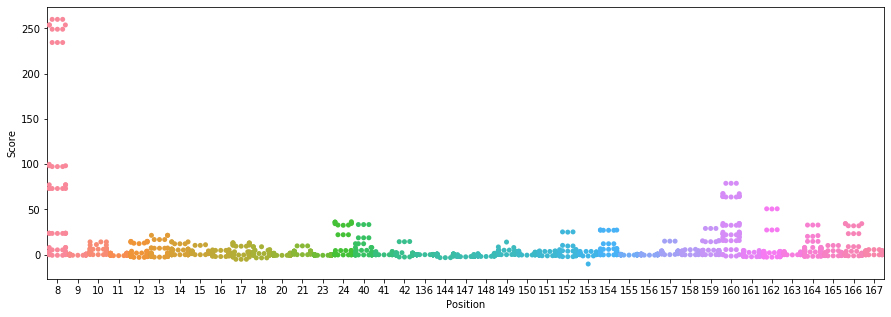

In [17]:
import matplotlib
matplotlib.pyplot.figure(figsize=(15,5))
seaborn.swarmplot(x='Position', y='Score', data=df)